In [231]:
from sklearn.datasets import fetch_openml
gina_prior2 = fetch_openml('gina_prior2', version=1)
gina_prior2.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [232]:
gina_prior2["DESCR"]

'**Author**:   \n**Source**: Unknown - Date unknown  \n**Please cite**:   \n\n**Note: Identical to the MNIST dataset?**\n\nDatasets from the Agnostic Learning vs. Prior Knowledge Challenge (http://www.agnostic.inf.ethz.ch)\n\nDataset from: http://www.agnostic.inf.ethz.ch/datasets.php\n\nModified by TunedIT (converted to ARFF format)\n\n\nGINA is digit recognition database\n\nThe task of GINA is handwritten digit recognition.\n\nData type: non-sparse\nNumber of features: 784\nNumber of examples and check-sum:\nTot_ex Check_sum\n3468 90979365.00\n\nDownloaded from openml.org.'

In [233]:
X, y = gina_prior2["data"], gina_prior2["target"]

In [234]:
X = X.to_numpy()
y = y.to_numpy()

In [235]:
X.shape

(3468, 784)

In [236]:
y.shape

(3468,)

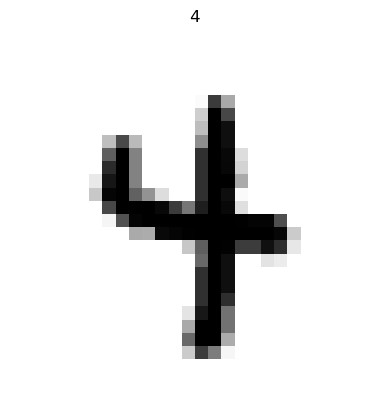

In [237]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_sample(i):
    plt.imshow(X[i].reshape(28, 28), cmap="binary")
    plt.axis("off")
    plt.title(y[i])
    plt.show()

some_digit = X[3]
plot_sample(3)

In [238]:
y[3]

'4'

In [239]:
import numpy as np
y = y.astype(np.uint8)

In [240]:
X_train, X_test, y_train, y_test = X[:2000], X[2000:], y[:2000], y[2000:]

In [241]:
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

In [242]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=110)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=110)

In [243]:
sgd_clf.predict([X_train[3]])

array([ True])

In [244]:
sgd_clf.predict(X_train[3].reshape(1, -1))

array([ True])

In [245]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_4[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9295352323838081
0.9565217391304348
0.9744744744744744


In [246]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_4, cv=5, scoring="accuracy")

array([0.9675, 0.9625, 0.96  , 0.945 , 0.9725])

In [247]:
from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [248]:
never_4_clf = Never4Classifier()
cross_val_score(never_4_clf, X_train, y_train_4, cv=5, scoring="accuracy")

array([0.905 , 0.9025, 0.895 , 0.9025, 0.9275])

In [249]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=5)

In [250]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4, y_train_pred)

array([[1774,   39],
       [  38,  149]], dtype=int64)

In [251]:
y_train_perfect_predictions = y_train_4  # pretend we reached perfection
confusion_matrix(y_train_4, y_train_perfect_predictions)

array([[1813,    0],
       [   0,  187]], dtype=int64)

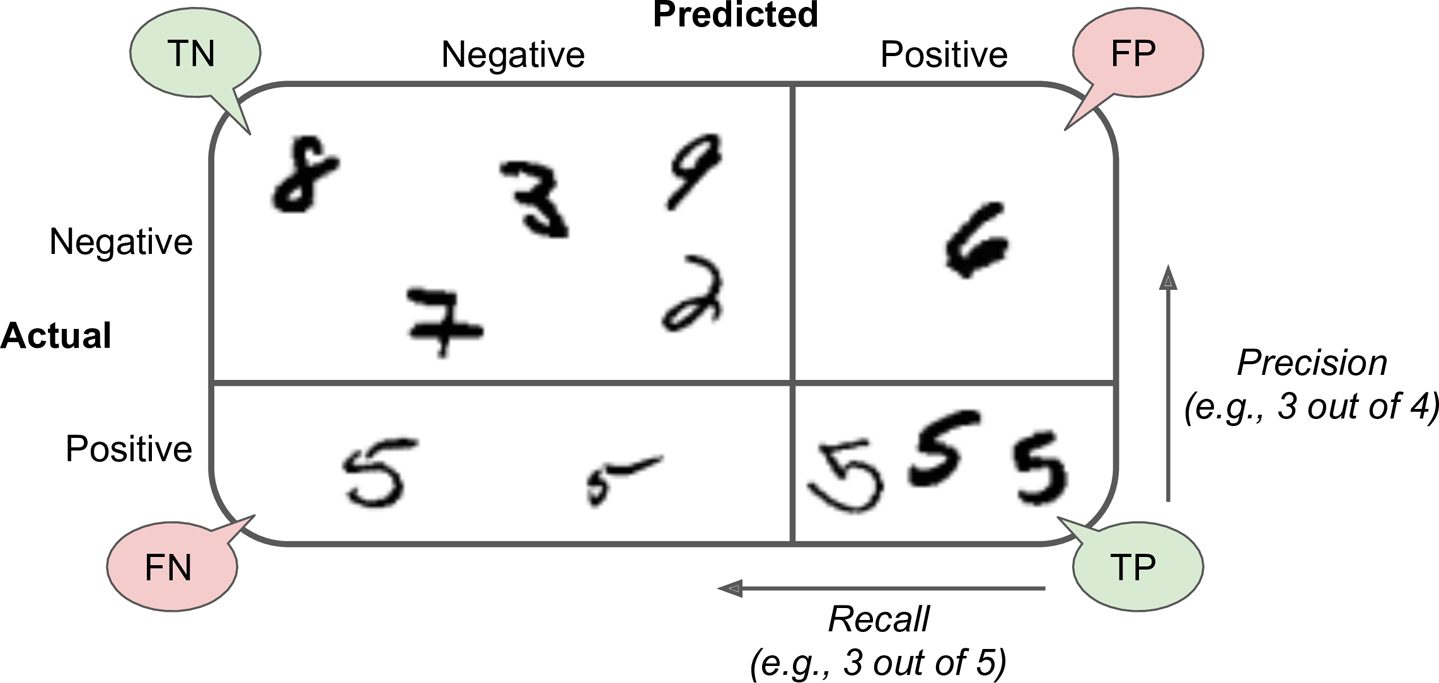

In [252]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_4, y_train_pred)
recall_score(y_train_4, y_train_pred)

0.7967914438502673

In [253]:
from sklearn.metrics import f1_score
f1_score(y_train_4, y_train_pred)

0.7946666666666666

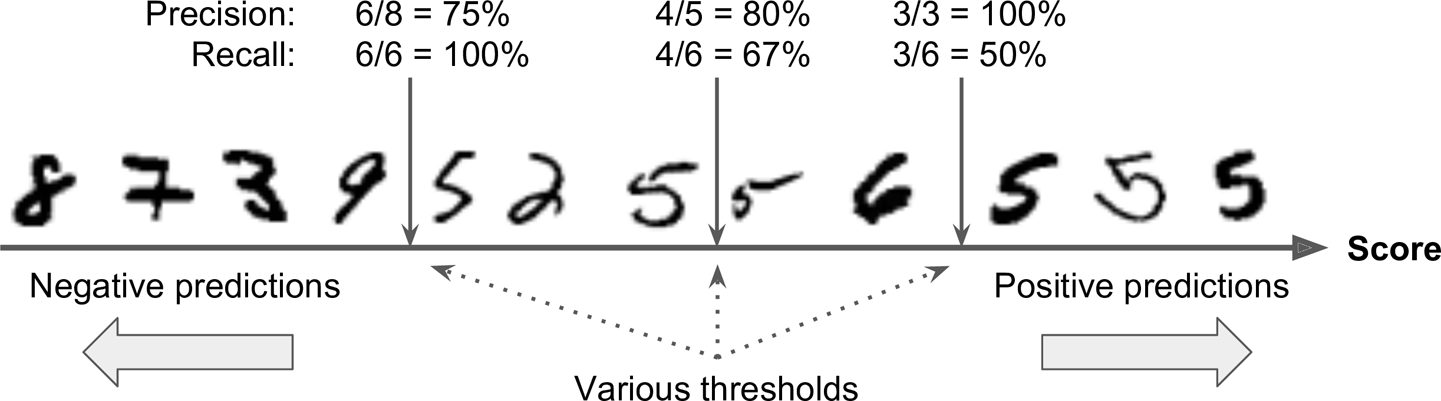

In [254]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([79014.74782344])

In [255]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [256]:
threshold = -100
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [257]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=5,
                             method="decision_function")
y_scores.shape

(2000,)

In [258]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

In [259]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.show()

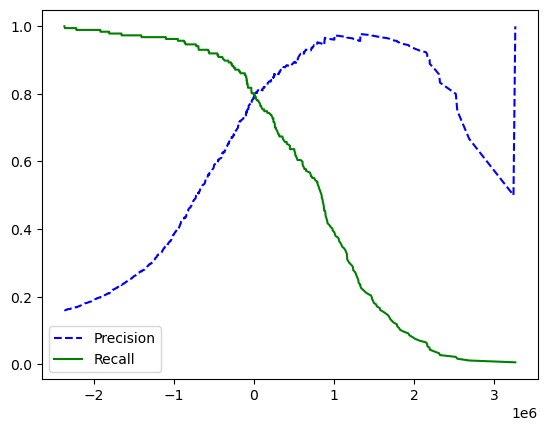

In [260]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [261]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [262]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [263]:
precision_score(y_train_4, y_train_pred_90)

0.904

In [264]:
recall_score(y_train_4, y_train_pred_90)

0.6042780748663101

In [265]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

In [266]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

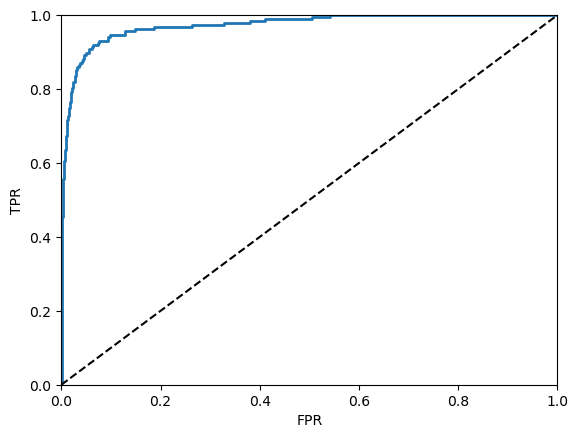

In [267]:
plot_roc_curve(fpr, tpr)

In [268]:
from sklearn.metrics import roc_auc_score

In [269]:
roc_auc_score(y_train_4, y_scores)

0.9735156962047719

In [270]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=5, method="predict_proba")

In [271]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4, y_scores_forest)

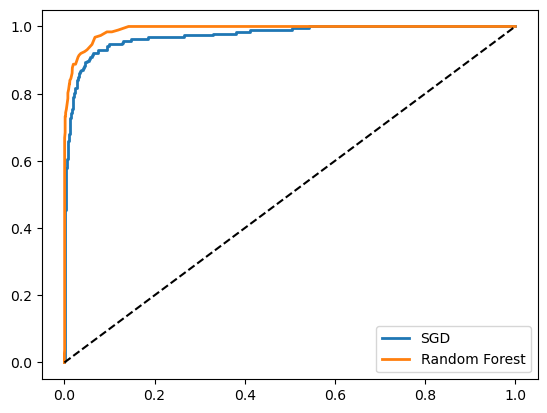

In [272]:
plt.plot(fpr, tpr, linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show()

In [273]:
roc_auc_score(y_train_4, y_scores_forest)

0.9909654279402179

In [274]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([4], dtype=uint8)

In [275]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[-0.29999772,  1.76679409,  1.73153873,  4.06277733,  9.30029122,
         6.20789994,  1.7634246 ,  7.11461716,  5.12733799,  8.28425544]])

In [276]:
np.argmax(some_digit_scores)

4

In [277]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [278]:
svm_clf.classes_[1]

1

In [279]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([4], dtype=uint8)

In [280]:
len(ovr_clf.estimators_)

10

In [281]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [282]:
sgd_clf.decision_function([some_digit])

array([[-4234783.46425554, -1161205.33967433, -1841386.1082411 ,
         -849024.131241  ,   553245.85859094,  -720926.23424897,
        -1564131.43449236, -1404566.64991127,  -646084.73261015,
         -421369.49146767]])

In [283]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.825 , 0.7925, 0.8475, 0.795 , 0.835 ])

$x'=\frac{x-\mu}{\sigma}$

In [284]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring="accuracy")

array([0.835 , 0.8225, 0.855 , 0.8375, 0.86  ])

In [285]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[181,   0,   6,   2,   2,   7,   4,   0,   1,   0],
       [  0, 197,   2,   1,   0,   0,   0,   1,  12,   0],
       [  6,   2, 148,   7,   6,   3,   5,   1,   5,   0],
       [  3,   1,   3, 150,   0,  11,   1,   1,  10,   2],
       [  2,   0,   2,   0, 151,   3,   1,   1,   8,  19],
       [  3,   2,   1,  12,   6, 152,   8,   2,   6,   6],
       [  1,   3,   4,   0,   0,   7, 186,   0,   2,   0],
       [  2,   1,   2,   1,   7,   1,   0, 193,   0,  16],
       [  1,   6,   8,   5,   0,   7,   3,   3, 141,  10],
       [  3,   1,   0,   2,  13,   2,   0,  13,   5, 185]], dtype=int64)

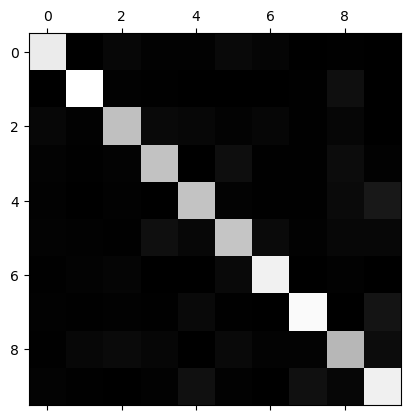

In [286]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [287]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

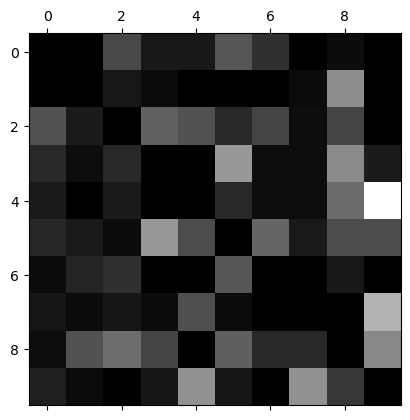

In [288]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [289]:
class_a = 1
class_b = 2
X_aa = X_train[(y_train == class_a) & (y_train_pred == class_a)]
X_ab = X_train[(y_train == class_a) & (y_train_pred == class_b)]
X_ba = X_train[(y_train == class_b) & (y_train_pred == class_a)]
X_bb = X_train[(y_train == class_b) & (y_train_pred == class_b)]

In [290]:
def plot_digit(instances, image_per_row=5, size=28, **options):
    image_per_row = min(image_per_row, len(instances))
    images = [x.reshape(size, size) for x in instances]
    n_rows = (len(instances) - 1) // image_per_row + 1
    row_images = []
    n_empty = n_rows * image_per_row - len(instances)
    for row in range(n_rows):
        r_img = images[row * image_per_row : (row + 1) * image_per_row]
        row_images.append(np.concatenate(r_img, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary', **options)
    plt.axis('off')

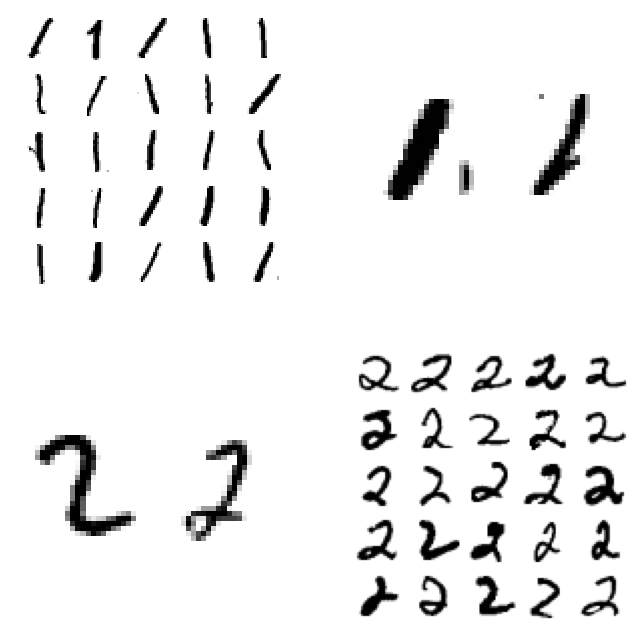

In [291]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digit(X_aa[:25], image_per_row=5, size=28)
plt.subplot(222); plot_digit(X_ab[:25], image_per_row=5, size=28)
plt.subplot(223); plot_digit(X_ba[:25], image_per_row=5, size=28)
plt.subplot(224); plot_digit(X_bb[:25], image_per_row=5, size=28)
plt.show()

In [292]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [293]:
knn_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False, False]])

In [294]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.9268100968356225

In [295]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


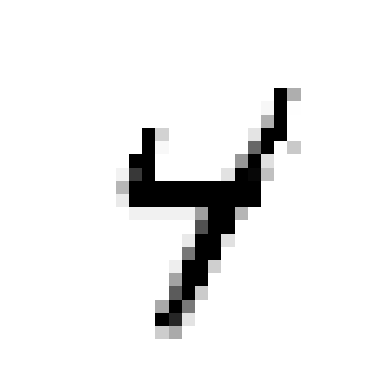

In [296]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)